In [1]:
# @formatter:off
import random

import numpy as np
import sklearn.ensemble
%load_ext autoreload
%autoreload 2
# @formatter:on
import os

print(os.getcwd())
os.chdir('../')

/home/viktor/workspace/smaite/notebooks


In [2]:
# @formatter:off
files = !ls data/*csv.jsonl
# @formatter:on

In [3]:
files = [f for f in files if 'sample' not in f and 'augmented' not in f and 'processed' not in f]
assert len(files) == 8

In [4]:
import json
from tqdm.notebook import tqdm
from unidecode import unidecode


def load_json(d):
    try:
        return json.loads(d, strict=False)
    except Exception as e:
        print("FEK")
        print(d)
        print(unidecode(d))
        return json.loads(unidecode(d), strict=False)


def load_jsonl(path: str):
    print("loading", path)
    with open(path) as f:
        return [load_json(d) for d in tqdm(f.readlines())]


datasets = [load_jsonl(p) for p in files]


loading data/bbc.csv.jsonl


  0%|          | 0/246 [00:00<?, ?it/s]

loading data/climatefeedback.csv.jsonl


  0%|          | 0/136 [00:00<?, ?it/s]

loading data/factcheck.csv.jsonl


  0%|          | 0/6000 [00:00<?, ?it/s]

loading data/fullfact.csv.jsonl


  0%|          | 0/4060 [00:00<?, ?it/s]

loading data/nytimes.csv.jsonl


  0%|          | 0/508 [00:00<?, ?it/s]

loading data/politifact.csv.jsonl


  0%|          | 0/5400 [00:00<?, ?it/s]

loading data/snopes.csv.jsonl


  0%|          | 0/4499 [00:00<?, ?it/s]

loading data/washingtonpost.csv.jsonl


  0%|          | 0/1416 [00:00<?, ?it/s]

In [5]:
from bs4 import BeautifulSoup


def fix_bbc(d):
    soup = BeautifulSoup(d['html_article'])
    texts = [t for t in soup.find_all(attrs={'data-component': 'text-block'}) if
             t.text.lower() not in ("read more from reality check", "send us your questions")]
    article = '\n'.join(d.text for d in texts)
    links = [a['href'] for t in texts for a in t.find_all(name='a')]
    d['text_article'] = article
    d['links_article'] = links
    return d


datasets[0] = [fix_bbc(d) for d in datasets[0]]

In [6]:
def fix_factchck(d):
    soup = BeautifulSoup(d['html_article'])
    header = [t for t in soup.find_all(name='h3') if t.text]
    texts = [t for t in soup.find_all(name='p') if t.text]
    article = '\n'.join(d.text for d in header + texts)
    #links = [a['href'] for t in texts for a in t.find_all(name='a')]
    d['text_article'] = article
    #d['links_article'] = links
    return d


datasets[0] = [fix_factchck(d) for d in datasets[3]]

In [7]:
import bs4
from copy import deepcopy


def fix_snopes(d):
    new_d = deepcopy(d)
    soup = BeautifulSoup(d['html_article'])
    soup.extract('script')
    texts = []
    for t in soup.find_all(name='p'):
        texts.append(t)

    article = '\n'.join(t.text.strip() for t in texts)
    #links = [a['href'] for t in texts for a in t.find_all(name='a')]
    new_d['text_article'] = article
    return new_d


# print(datasets[6][1336]['text_article'])
# print(20*'----')
datasets[6] = [fix_snopes(d) for d in datasets[6]]

In [8]:
def fix_wp(d):
    new_d = deepcopy(d)
    soup = BeautifulSoup(d['html_article'])
    texts = [t for t in soup.find_all(attrs={'data-qa': ['drop-cap-letter', 'article-header']}) if
             t.text.lower() not in ("read more from reality check", "send us your questions")]
    article = '\n'.join(d.text for d in texts if not any(
        d.text.lower().startswith(n) for n in ("send us facts to check", "sign up for the fact checker", "the fact checker is", "(about our rating")))
    new_d['text_article'] = article
    return new_d


datasets[7] = [fix_wp(d) for d in datasets[7]]

In [9]:
print(datasets[7][1336]['html_article'])

<div class="article-body"><div class="teaser-content"><section><div class=""><p class="font-copy font--article-body gray-darkest ma-0 pb-md" data-el="text" data-qa="drop-cap-letter">As President Trump barnstorms the country, going from rally to rally to bolster votes for Republican candidates, his rhetoric has turned increasingly darker.</p></div><div class=""><p class="font-copy font--article-body gray-darkest ma-0 pb-md" data-el="text" data-qa="drop-cap-letter">We’ve documented before that <a href="https://www.washingtonpost.com/news/fact-checker/wp/2018/07/10/anatomy-of-a-trump-rally-76-percent-of-claims-are-false-misleading-or-lacking-evidence/?utm_term=.6ebad0bf0e9f&amp;itid=lk_inline_manual_3" target="_blank">at least 70 percent</a> of the <a href="https://www.washingtonpost.com/politics/2018/09/12/anatomy-trump-rally-percent-claims-are-false-misleading-or-lacking-evidence/?utm_term=.5c5dbab8c0f9&amp;itid=lk_inline_manual_3" target="_blank">factual claims</a> he makes at his rall

In [10]:
datasets[0][0].keys()

dict_keys(['id', 'text', 'claimant', 'claimDate', 'cR_p_name', 'cR_p_site', 'cR_url', 'cR_title', 'cR_reviewDate', 'cR_textualRating', 'lCode', 'links_article', 'text_article', 'html_article'])

In [11]:
def replace_label(label):
    for k, v in coarse_map.items():
        if label in v:
            return k
    return 'UNKNOWN'


def process_label(label):
    label = str(label).lower().replace('_', ' ').replace('- ', '').replace('.', '').replace('this', '').replace('fasle', 'false')
    label = label.replace('may be', '').replace('the', '').replace('claim', '').replace(' is ', ' ').replace('just', '').replace('flat', '').strip()
    if len(label) < 40:
        if any(label.startswith(n) for n in ['no', 'false']):
            return 'false'
        elif any(c in label for c in ['misleading', 'context']):
            return 'misleading'
    return label

In [12]:
import matplotlib.pyplot as plt
import pandas as pd


def barh_from_counter(ctrs):
    index = ['TRUE', 'ALMOST', 'HALF', 'HARDLY', 'FALSE', 'MISLEADING', 'SATIRE']
    df = pd.DataFrame({k: [v.get(i, 0) for i in index] for k, v in ctrs.items()}, index)
    df.plot.barh()
    plt.show()


Dataset: data/climatefeedback.csv.jsonl
4
Dataset: data/factcheck.csv.jsonl
7
Dataset: data/nytimes.csv.jsonl
7
Dataset: data/politifact.csv.jsonl
7
Dataset: data/snopes.csv.jsonl
8
Dataset: data/washingtonpost.csv.jsonl
7


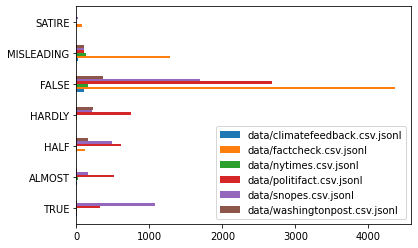

In [13]:
from collections import Counter


def label_distribution_ds(ds, name, cutoff=1):
    labels = [replace_label(process_label(d['cR_textualRating'])) for d in ds]
    full_ctr = Counter(labels)
    ctr = {x: y for x, y in full_ctr.most_common() if y >= cutoff}
    print('Dataset:', name)
    print(len(ctr))
    return ctr


coarse_map = {
    'TRUE': ['accurate', 'correct', 'true', 'legit'],
    'FALSE': ['inaccurate', 'unsupported', 'flawed reasoning', 'incorrect', 'lacks context', 'false', 'wrong', 'scam', 'falso', 'fake',
              'manipulated image', 'altered video', 'doctored image', 'hoax', 'faux', 'altered image', 'pants on fire', 'full flop',
              'legend' 'four pinocchios'],
    'MISLEADING': ['misleading', 'lacks context', 'missing context', 'misleading context', 'misattributed', 'out of context', 'exaggerated',
                   'exaggeration', 'unsubstantiated', 'outdated'],
    'ALMOST': ['imprecise', 'mostly correct', 'mostly accurate', 'correct but…', 'mostly true', 'lacks evidence', 'largely correct',
               'largely accurate', 'close to accurate', 'one pinocchio'],
    'HALF': ['mixture', 'mixed', 'half true', 'partly false', 'half-right, half-wrong', 'half flip', 'partially accurate', 'two pinocchios',
             'half flop'],
    'HARDLY': ['partly false', 'mostly false', 'three pinocchios'],
    'SATIRE': ['satire', 'false satire', 'april fool', 'originated as satire', 'labelled satire']
}
ctrs = dict()
for ds, f in zip(datasets, files):

    if all(n not in f for n in ['fullfact', 'bbc']):
        ctrs[f] = label_distribution_ds(ds, f)

barh_from_counter(ctrs)



In [14]:
def augment_labels(ds):
    for d in ds:
        d['label'] = replace_label(process_label(d['cR_textualRating']))


for ds, f in zip(datasets, files):
    if all(n not in f for n in ['fullfact', 'bbc']):
        augment_labels(ds)


In [15]:
import random


def does_output_make_sense(ds, name, k=5):
    print('Dataset:', name)
    for d in random.sample(ds, k):
        print(' rating:', d['cR_textualRating'])
        print(' title:', d['cR_title'])
        print()
    print('----' * 20)


for ds, f in zip(datasets, files):
    does_output_make_sense(ds, f, 10)


Dataset: data/bbc.csv.jsonl
 rating: The UN estimates that there were 8.8 million people in the UK in 2017 who were not born here, but that doesn’t mean the government has found homes for them.
 title: This viral image on immigration and homelessness has a fundamental flaw - Full Fact

 rating: This is far too high. There are various estimates for the prevalence of long Covid. The Office for National Statistics estimated that 7.5% of people infected with Covid-19 self-reported having long Covid three  months after infection which limited their  daily activities.
 title: Washington Post overstates prevalence of long Covid - Full Fact

 rating: Car accident victims who had their feet on the dashboard have suffered serious facial injuries.
 title: You are at risk of serious facial injuries if your feet are on the dashboard during a car crash - Full Fact

 rating: This is unlikely outside of some very particular circumstances.
 title: You almost certainly won’t get arrested for flying a Br

In [16]:
def augment_explanation(ds, concat=False):
    for d in ds:
        if concat:
            explanation = '. '.join((str(d['cR_textualRating']), d['cR_title']))
        else:
            explanation = str(d['cR_textualRating'])
        d['explanation'] = explanation


for ds, f in zip(datasets, files):
    augment_explanation(ds, concat=any(n in f for n in ['climatefeedback', 'factcheck']))


In [17]:
from handystuff.loaders import write_jsonl


def write_out_ds(ds, f):
    f = f.replace('data/', 'data/augmented-')
    print(f)
    write_jsonl(ds, f)


for ds, f in zip(datasets, files):
    write_out_ds(ds, f)


data/augmented-bbc.csv.jsonl
data/augmented-climatefeedback.csv.jsonl
data/augmented-factcheck.csv.jsonl
data/augmented-fullfact.csv.jsonl
data/augmented-nytimes.csv.jsonl
data/augmented-politifact.csv.jsonl
data/augmented-snopes.csv.jsonl
data/augmented-washingtonpost.csv.jsonl


In [20]:
#@formatter:off
!cd data/ && for i in augmented-bbc.csv.jsonl augmented-climatefeedback.csv.jsonl augmented-factcheck.csv.jsonl augmented-fullfact.csv.jsonl augmented-nytimes.csv.jsonl augmented-politifact.csv.jsonl augmented-snopes.csv.jsonl augmented-washingtonpost.csv.jsonl; do cat $i | mlr --ijsonl --ojsonl cut -f text,text_article,label,explanation > processed-$i; done
#@formatter:on